# Compare methods using Squair data

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functools
import numpy as np

In [115]:
data_path = '/data_volume/r_datasets/squair/'

In [116]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", ['turquoise', 'slategrey', 'silver'])

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

In [117]:
pal = [(64/255,224/255,208/255)]+sns.color_palette("Greys", 10)[4:]

### Compute the concordance curve

In [118]:
def concordance_curve(refs, x, k=300):
    overlap = []
    for i in range(1, k+1):
        
        ref_total = 0
        for ref in refs:
            ref_total += len(set(x[:i]) & set(ref[:i]))
        overlap.append(ref_total/len(refs))
        
    return np.arange(1, k+1), np.array(overlap)

In [119]:
def concordance_auc(refs, x, k=300):
    count = 0
    for i in range(1, k+1):
        
        ref_total = 0
        for ref in refs:
            ref_total += len(set(x[:i]) & set(ref[:i]))
            
        count += ref_total/len(refs)
        
    return count / (k*(k+1)/2)

### Read results - cell type comparison

In [127]:
datasets = [
    'Hagai2018_mouse-lps',
    'Hagai2018_mouse-pic',
    'Hagai2018_pig-lps',
    'Hagai2018_rabbit-lps',
    'Hagai2018_rat-lps',
    'Hagai2018_rat-pic',
]

bulk_methods = [
    ('bulk_DESeq2,test?LRT',['gene', 'log2FoldChange', 'pvalue', 'padj']),
    # ('bulk_DESeq2,test?Wald',['gene', 'log2FoldChange', 'pvalue', 'padj']),
    ('bulk_edgeR,test?LRT',['gene', 'logFC', 'PValue', 'FDR']),
    # ('bulk_edgeR,test?QLF',['gene', 'logFC', 'PValue', 'FDR']),
    ('bulk_limma,mode?voom',['gene', 'logFC', 'P.Value', 'adj.P.Val'])
]

sc_methods = [ 
    ('LR',['gene','avg_log2FC', 'p_val', 'p_val_adj']),
    ('MAST',['gene','avg_log2FC', 'p_val', 'p_val_adj']),
    ('bimod',['gene','avg_log2FC', 'p_val', 'p_val_adj']),
    ('negbinom',['gene','avg_log2FC', 'p_val', 'p_val_adj']),
    ('poisson',['gene','avg_log2FC', 'p_val', 'p_val_adj']),
    ('pseudobulk_DESeq2,test?LRT',['gene','avg_logFC', 'pvalue', 'p_val_adj']),
    ('pseudobulk_DESeq2,test?Wald',['gene','avg_logFC', 'pvalue', 'p_val_adj']),
    ('pseudobulk_edgeR,test?LRT',['gene','avg_logFC', 'p_val', 'p_val_adj']),
    ('pseudobulk_edgeR,test?QLF',['gene','avg_logFC', 'p_val', 'p_val_adj']),
    ('pseudobulk_limma,mode?voom',['gene','avg_logFC', 'p_val', 'p_val_adj']),
    ('t',['gene','avg_log2FC', 'p_val', 'p_val_adj']),
    ('wilcox',['gene','avg_log2FC', 'p_val', 'p_val_adj']),
    ('memento',['gene', 'logFC', 'PValue', 'FDR']),
]

In [128]:
def read_bulk_dataset(dataset, method, cols):
    
    df = pd.read_csv(data_path + 'bulk_rnaseq/results/{}-de_test={}.csv'.format(dataset, method))[cols]
    df.columns = ['gene','logFC','PValue', 'FDR']
    df.index = df['gene']
    return df

def read_sc_dataset(dataset, method, cols):
    
    df = pd.read_csv(data_path +  'sc_rnaseq/results/{}-de_test={}-shuffle_replicates=NO.csv'.format(dataset, method))[cols]
    df.columns = ['gene','logFC','PValue', 'FDR']
    df.index = df['gene']
    return df

all_results = []
for dataset in datasets:
    
    bulk_results = [read_bulk_dataset(dataset, method, cols) for method, cols in bulk_methods]
    sc_results = [read_sc_dataset(dataset, method, cols) for method, cols in sc_methods]
    
    gene_list = gene_lists = [set(res['gene']) for res in sc_results] + [set(res['gene']) for res in bulk_results]
    genes = list(functools.reduce(lambda x,y: x & y, gene_lists))

    bulk_results = [res.loc[genes].sort_values('FDR') for res in bulk_results]
    sc_results = [res.loc[genes].sort_values('FDR') for res in sc_results]
    
    scores = [(sc_methods[idx][0], dataset, concordance_auc([b_res.index for b_res in bulk_results], res.index, k=100)) for idx, res in enumerate(sc_results)]
    all_results+=scores
    

In [130]:
df = pd.DataFrame(all_results, columns=['name', 'numcells', 'auc'])

<AxesSubplot: xlabel='auc', ylabel='name'>

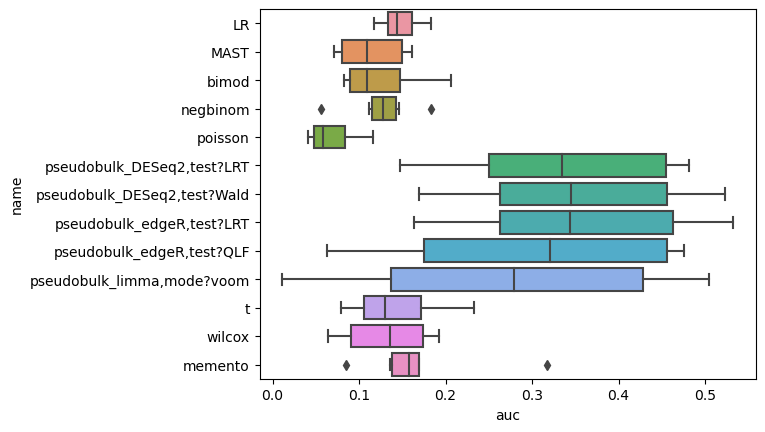

In [133]:
sns.boxplot(y='name', x='auc', data=df)

In [58]:
len(genes)

14309

In [11]:
name_paths = [
    ('bulk_edger_lrt','T4_vs_cM.bulk.edger_lrt.csv', ['logFC','PValue', 'FDR']), 
    ('bulk_edger_qlft','T4_vs_cM.bulk.edger_qlft.csv', ['logFC','PValue', 'FDR']), 
    ('bulk_deseq2_wald', 'T4_vs_cM.bulk.deseq2_wald.csv', ['log2FoldChange','pvalue', 'padj']),
    ('bulk_deseq2_lrt', 'T4_vs_cM.bulk.deseq2_lrt.csv', ['log2FoldChange','pvalue', 'padj']),
    ('pseudobulk_edger','T4_vs_cM.pseudobulk.edger_lrt.csv', ['logFC','PValue', 'FDR']),
    ('pseudobulk_deseq2','T4_vs_cM.pseudobulk.deseq2_wald.csv', ['log2FoldChange','pvalue', 'padj']),
    ('ttest','T4_vs_cM.sc.ttest.csv', ['logFC','PValue', 'FDR']),
    # ('WLS','T4_vs_cM.sc.wls.csv', ['logFC','PValue', 'FDR']),
    ('sum_GLM', 'T4_vs_cM.sc.sum_glm.csv', ['logFC','PValue', 'FDR']),
    # ('scaled_mean_GLM', 'T4_vs_cM.sc.scaled_mean_glm.csv', ['logFC','PValue', 'FDR']),
    # ('scaled_iv_mean_GLM', 'T4_vs_cM.sc.scaled_iv_mean_glm.csv', ['logFC', 'PValue', 'FDR']),
    ('weighted_mean_GLM', 'T4_vs_cM.sc.weighted_mean_glm.csv', ['logFC','PValue', 'FDR']),
    ('memento', 'T4_vs_cM.sc.memento.csv', ['de_coef','de_pval', 'de_fdr']),
    ('weighted_mean_WLS', 'T4_vs_cM.sc.weighted_mean_wls.csv', ['logFC','PValue', 'FDR'])
    
]
results = [pd.read_csv(data_path + path, index_col=0)[cols].rename(columns=dict(zip(cols,['logFC','PValue', 'FDR'])))  for name, path, cols in name_paths]
gene_lists = [set(res.index) for res in results]
genes = list(functools.reduce(lambda x,y: x & y, gene_lists))
results = [res.loc[genes].sort_values('FDR') for res in results]

curves = [
    concordance_curve(
        results[0].index, 
        results[1].index, 
        results[2].index,
        results[3].index,
        res.index) for res in results[4:]]

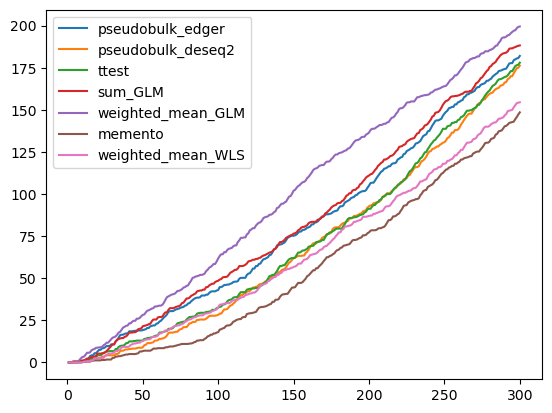

In [12]:
for idx, (x,y) in enumerate(curves):
    plt.plot(x,y, label=name_paths[idx+4][0])
plt.legend()

<AxesSubplot: >

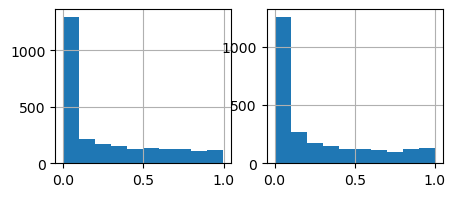

In [13]:
plt.figure(figsize=(5,2))

plt.subplot(1, 2, 1)
results[4]['PValue'].hist()

plt.subplot(1, 2, 2)
results[-3]['PValue'].hist()

### Read results with repeated trials

In [13]:
all_results = []
for numcells in [150]:
    for trial in range(50):        
        name_paths = [
            ('bulk_edger_lrt','T4_vs_cM.bulk.edger_lrt.{}.{}.csv'.format(numcells, trial), ['logFC','PValue', 'FDR']), 
            ('bulk_edger_qlft','T4_vs_cM.bulk.edger_qlft.{}.{}.csv'.format(numcells, trial), ['logFC','PValue', 'FDR']),
            ('bulk_deseq2_wald', 'T4_vs_cM.bulk.deseq2_wald.{}.{}.csv'.format(numcells, trial), ['log2FoldChange','pvalue', 'padj']),
            ('bulk_deseq2_lrt', 'T4_vs_cM.bulk.deseq2_lrt.{}.{}.csv'.format(numcells, trial), ['log2FoldChange','pvalue', 'padj']),
            ('edgeR','T4_vs_cM.pseudobulk.edger_lrt.{}.{}.csv'.format(numcells, trial), ['logFC','PValue', 'FDR']),
            ('DESeq2','T4_vs_cM.pseudobulk.deseq2_wald.{}.{}.csv'.format(numcells, trial), ['log2FoldChange','pvalue', 'padj']),
            ('t-test','T4_vs_cM.sc.ttest.{}.{}.csv'.format(numcells, trial), ['logFC','PValue', 'FDR']),
            ('MWU','T4_vs_cM.sc.mwu.{}.{}.csv'.format(numcells, trial), ['logFC','PValue', 'FDR']),
            ('MAST','T4_vs_cM.sc.MAST.{}.{}.csv'.format(numcells, trial), ['coef','Pr(>Chisq)', 'fdr']),
            ('memento', 'T4_vs_cM.sc.weighted_mean_glm.{}.{}.csv'.format(numcells, trial), ['logFC','PValue', 'FDR']),
        ]
        results = [pd.read_csv(data_path + path, index_col=0)[cols].rename(columns=dict(zip(cols,['logFC','PValue', 'FDR'])))  for name, path, cols in name_paths]
        gene_lists = [set(res.index) for res in results]
        genes = list(functools.reduce(lambda x,y: x & y, gene_lists))
        results = [res.loc[genes].sort_values('FDR') for res in results]

        scores = [
            (name_paths[idx+4][0].replace('_', '\n'), numcells, concordance_auc(
                results[0].index, 
                results[1].index, 
                results[2].index,
                results[3].index,
                res.index)) for idx, res in enumerate(results[4:])]
        all_results+=scores
        
        curves = [
            concordance_curve(
                results[0].index, 
                results[1].index, 
                results[2].index,
                results[3].index,
                res.index) for res in results[4:]]

In [14]:
# plt.figure(figsize=(3,3))
# for idx, (x,y) in enumerate(curves):
#     plt.plot(x,y, label=name_paths[idx+4][0])
# plt.legend()
# plt.xlabel('Number of top genes')
# plt.ylabel('Overlap with bulk RNA-seq')

In [15]:
df = pd.DataFrame(all_results, columns=['name', 'numcells', 'auc'])

/tmp/ipykernel_14545/200401537.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
/tmp/ipykernel_14545/200401537.py:14: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.stripplot(


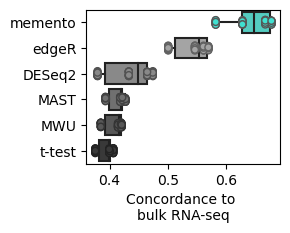

In [23]:
plt.figure(figsize=(2.5,2))
sns.boxplot(
    y='name',
    x='auc', 
    data=df.query('numcells==150'), 
    order=[
        'memento',
        'edgeR',
        'DESeq2',
        'MAST',
        'MWU',
        't-test',],
    palette=pal)
sns.stripplot(
    y='name',
    x='auc', 
    data=df.query('numcells==150'), 
    order=[
        'memento',
        'edgeR',
        'DESeq2',
        'MAST',
        'MWU',
        't-test',],
    linewidth=1,
    palette=pal)
plt.xlabel('Concordance to \nbulk RNA-seq')
plt.ylabel('')
plt.savefig('lupus_bulk_comparison.pdf', bbox_inches='tight')

### Single example

In [139]:
name_paths = [
    ('bulk_edger_lrt','T4_vs_cM.bulk.edger_lrt.csv', ['logFC','PValue', 'FDR']), 
    ('bulk_edger_qlft','T4_vs_cM.bulk.edger_qlft.csv', ['logFC','PValue', 'FDR']),
    ('bulk_deseq2_wald', 'T4_vs_cM.bulk.deseq2_wald.csv', ['log2FoldChange','pvalue', 'padj']),
    ('bulk_deseq2_lrt', 'T4_vs_cM.bulk.deseq2_lrt.csv', ['log2FoldChange','pvalue', 'padj']),
    ('pseudobulk_edger','T4_vs_cM.pseudobulk.edger.csv', ['logFC','PValue', 'FDR']),
    ('pseudobulk_deseq2','T4_vs_cM.pseudobulk.deseq2.csv', ['log2FoldChange','pvalue', 'padj']),
    ('ttest','T4_vs_cM.sc.ttest.csv', ['logFC','PValue', 'FDR']),
    ('weighted_mean_GLM', 'T4_vs_cM.sc.weighted_mean_glm.csv', ['logFC','PValue', 'FDR']),
]
results = [pd.read_csv(data_path + path, index_col=0)[cols].rename(columns=dict(zip(cols,['logFC','PValue', 'FDR'])))  for name, path, cols in name_paths]
gene_lists = [set(res.index) for res in results]
genes = list(functools.reduce(lambda x,y: x & y, gene_lists))
results = [res.loc[genes].sort_values('FDR') for res in results]

curves = [
    concordance_curve(
        results[0].index, 
        results[1].index, 
        results[2].index,
        results[3].index,
        res.index) for res in results[4:]]

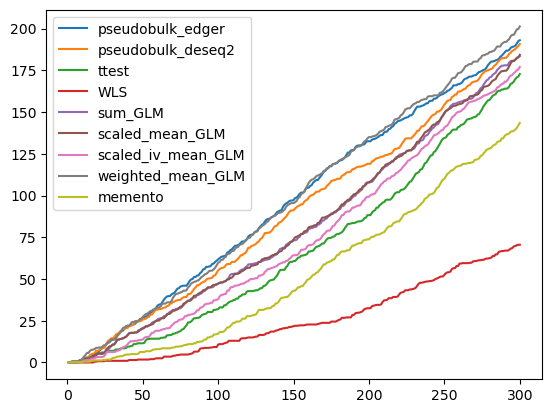

In [142]:
for idx, (x,y) in enumerate(curves):
    plt.plot(x,y, label=name_paths[idx+4][0])
plt.legend()